## ML Model
### Constructing, training and Evaluation of at least three different models

### Cunstruction:
- Pipeline of multiple different ML-models

### Training:

- Training the different models with the splitted training dataset. Combining different combinations of features. USe vizualisation to see correlence between feature and goals scored in a match.

    - Models:
    - Multiple Linear Regression
    - Logistic Regression
    - KNN : KNearestNeighbours
        - Multiple k's
    - DecisionTreeRegressor
    - RandomForestRegressor
    - DecisionTreeClassifier
    - RandomForestClassifier
        - Different estimators (Ex n_estimators = 500)
        - mse = log_loss(y_val, pred)
    - MLPClassifier
    
#### Evaluation:
- Evaluate the different trained models with the validation dataset, check for over-/underfit:
    Methods:
    - MSE
        - Lower == Better
    - Delta
        - Lower == Lower MSE will give lower test_rmse hence lower delta better

In [1]:
from sklearn.linear_model import LinearRegression             as LR
from sklearn.linear_model import LogisticRegression           as LogReg

from sklearn.tree import DecisionTreeRegressor                as DTR
from sklearn.ensemble import RandomForestRegressor            as RFR
from sklearn.neighbors import KNeighborsRegressor             as KNN
from sklearn.tree import DecisionTreeClassifier               as DTC
from sklearn.ensemble import RandomForestClassifier           as RFC
from sklearn.neural_network import MLPClassifier              as MLPC

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt 

import pandas as pd
import numpy as np

from matplotlib.pyplot import figure

import math
import random

from itertools import product
from itertools import combinations
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectFromModel
import plotly.figure_factory as ff
plt.style.use('fivethirtyeight')
pd.set_option('display.max_rows', 1000)

In [2]:
numeric_features = ['HomeGround', 'AvgGoalsScored_90', 'GlsRatio', '%FPla', 'Avg_Age', 'OppGlsAgst90', 'tablePos', 'points']
## Reading the data created in the preparation stored in two CSV files
games = pd.read_csv("training_data_games.csv")
test_games = pd.read_csv("test_data_games.csv")

X = games[numeric_features]
Y = games['Goals']
X_train, X_valtest, Y_train, y_valtest = train_test_split(X, Y, test_size=0.3, random_state=69)
X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=69)


## Creating a dummy-model, where the predicted score is a random number from a normal distribution from 0 - 6 (Max and min values of train-data). By doing this 30 times and taking the average of the RMSEs of the rounds, we get a more trustworthy RMSE to use for later evaluation:

In [3]:
def do_random_normal_predictions():
    random_predictions = []
    for i in range(len(X_test)):
        random_predictions.append(random.uniform(0, max(Y_train)))

    random_prediction_RMSE = mean_squared_error(
        Y_test, 
        random_predictions, 
        squared=False
    )
    return random_prediction_RMSE
normal_list = [do_random_normal_predictions() for x in range(30)]
avg_random_prediction_RMSE = np.average(normal_list)
print(f"RMSE from random normal-distribution: {avg_random_prediction_RMSE}")


RMSE from random normal-distribution: 2.569070225857679


## Creating a second dummy-model with the average amount of goals from the test-dataset, and comparing this with the actual Y_test-values:

In [4]:
avg_of_train_data = round(np.average(Y_train), 4)
print(f"Average goals scored from train-data: {avg_of_train_data}")
avg_predictions = [avg_of_train_data for i in range(len(Y_val))]
average_prediction_RMSE = mean_squared_error(
    Y_val, 
    avg_predictions, 
    squared=False
)
print(f"RMSE from average prediction: {average_prediction_RMSE}")

Average goals scored from train-data: 1.5591
RMSE from average prediction: 1.448303424700777


In [5]:
# imputers and different models
imputers = {
    'median': SimpleImputer(strategy='median'),
    'mean': SimpleImputer(strategy='mean'),
    'most_frequent' : SimpleImputer(strategy='most_frequent')
}
models = {'LinearRegression' : LR(positive=True),
          'LogisticRegression' : LogReg(),
          'DecisionTreeRegressor' : DTR(),
          'RandomForestRegressor_n100' : RFR(n_estimators = 100),
          'RandomForestRegressor_n200' : RFR(n_estimators = 200),
          'RandomForestRegressor_n300' : RFR(n_estimators = 300),
          'RandomForestRegressor_n400' : RFR(n_estimators = 400),
          'RandomForestRegressor_n500' : RFR(n_estimators = 500),
          'KNeighborsRegressor_03n' : KNN(n_neighbors=3),
          'KNeighborsRegressor_05n' : KNN(n_neighbors=5),
          'KNeighborsRegressor_07n' : KNN(n_neighbors=7),
          'KNeighborsRegressor_10n' : KNN(n_neighbors=10),
          'KNeighborsRegressor_13n' : KNN(n_neighbors=13),
          'DecisionTreeClassifier' : DTC(), 
          'RandomForestClassifier_250' : RFC(n_estimators=250),
          'RandomForestClassifier_500' : RFC(n_estimators=500),
          'RandomForestClassifier_750' : RFC(n_estimators=750),
          'RandomForestClassifier_1000' : RFC(n_estimators=1000),
             }
scalers = {
    'standard' : StandardScaler(copy = True, with_mean = True, with_std = True),
    'MinMax'   : MinMaxScaler(),
    'MaxAbs'   : MaxAbsScaler()
}
all_combinations = []
## Creating all combinations of imputers, models and scalers to find the optimal combination
for imp in imputers.items():
    for model in models.items():
        for scaler in scalers.items():
            this_set = [imp, model, scaler]
            all_combinations.append(this_set)
            


numeric_features = ['HomeGround', 'AvgGoalsScored_90', 'GlsRatio', '%FPla', 'Avg_Age', 'OppGlsAgst90', 'tablePos', 'points']



In [6]:
pipes = {imputer_key + '_' + model_key + "_" + scaler_key: Pipeline(
        steps=[
            ('preprocess', ColumnTransformer(
                transformers=[
                    ('num', Pipeline(
                        steps = [
                            ('impute', imputer), 
                            ('scaler', StandardScaler())
                        ]),
                     numeric_features)
                ]
            )
            ),
            ('regress', model)
        ]
    )
             for (imputer_key, imputer), (model_key, model), (scaler_key, scaler) in all_combinations}
    

In [15]:
validation_rmse = pd.DataFrame(
    {key: mean_squared_error(
        Y_val, 
        pipe.fit(X_train, Y_train).predict(X_val), 
        squared=False
    )
     for key, pipe in pipes.items()}.items(),
    columns=['model', 'rmse']
)
print("DONE")


DONE


In [16]:
models_w_atributes = []
models_test_rmse = []
models_delta = []
for model in validation_rmse['model']:
    
    ## Get the model to get its atributes
    mod = (pipes[model].steps)[-1][1]
    models_w_atributes.append(mod)
    
    m = pipes[model]
    test_rmse = mean_squared_error(Y_test, m.predict(X_test), squared=False)
    models_test_rmse.append(test_rmse)
    rmse_val = (validation_rmse.loc[validation_rmse['model'] == model]).rmse
    rmse_val = list(rmse_val)[0]
    delta = test_rmse - rmse_val
    models_delta.append(delta)

## Adding column with the modelname and attributes
validation_rmse['models_w_Attributes'] = models_w_atributes
validation_rmse['test_rmse'] = models_test_rmse
validation_rmse['delta'] = models_delta
## Picking out the model with smallest RMSE and smallest delta for generalization error

best_model = pipes[validation_rmse.loc[np.argmin(validation_rmse.delta), 'model']]

print("Best Model Validation-RMSE: ")
print(validation_rmse.loc[np.argmin(validation_rmse.delta), ['model', 'rmse', 'test_rmse', 'delta']])
validation_rmse


Best Model Validation-RMSE: 
model        most_frequent_LinearRegression_standard
rmse                                         1.30743
test_rmse                                   1.544924
delta                                       0.237494
Name: 108, dtype: object


,model,rmse,models_w_Attributes,test_rmse,delta
0,median_LinearRegression_standard,1.302203,LinearRegression(positive=True),1.550734,0.248530
1,median_LinearRegression_MinMax,1.302203,LinearRegression(positive=True),1.550734,0.248530
2,median_LinearRegression_MaxAbs,1.302203,LinearRegression(positive=True),1.550734,0.248530
3,median_LogisticRegression_standard,1.453444,LogisticRegression(),1.942936,0.489492
4,median_LogisticRegression_MinMax,1.453444,LogisticRegression(),1.942936,0.489492
5,median_LogisticRegression_MaxAbs,1.453444,LogisticRegression(),1.942936,0.489492
6,median_DecisionTreeRegressor_standard,1.501157,DecisionTreeRegressor(),2.078912,0.577755
7,median_DecisionTreeRegressor_MinMax,1.558356,DecisionTreeRegressor(),2.078912,0.520556
8,median_DecisionTreeRegressor_MaxAbs,1.542230,DecisionTreeRegressor(),2.078912,0.536682
9,median_RandomForestRegressor_n100_standard,1.321711,"(DecisionTreeRegressor(max_features='auto', ra...",1.884003,0.562292


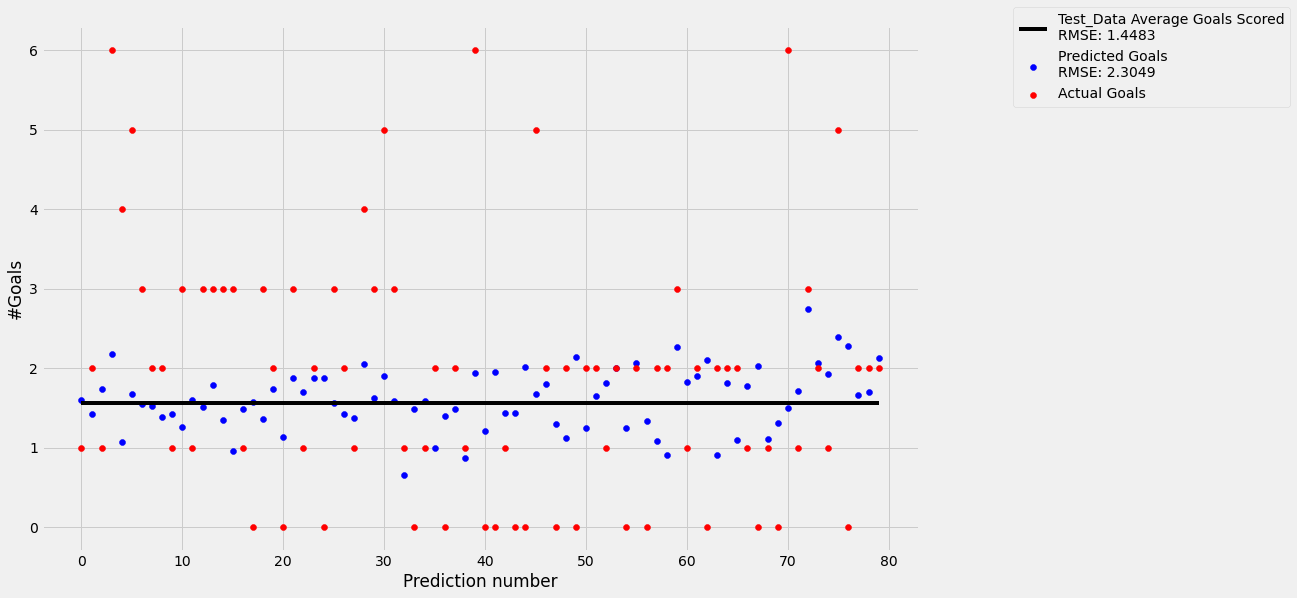

In [9]:

actual_y_test, predicted_y_test = Y_test, best_model.predict(X_test)

plt.figure(figsize=(14, 9))
plt.scatter(
    x = range(len(predicted_y_test)),
    y = predicted_y_test,
    label = f'Predicted Goals\nRMSE: {round(test_rmse, 4)}',
    c = 'b'
)

plt.scatter(
    x = range(len(actual_y_test)), 
    y = actual_y_test,
    label = 'Actual Goals',
    c = 'r'
)
plt.plot(
    [avg_of_train_data for i in range(len(actual_y_test))],
    c = 'black',
    label = f'Test_Data Average Goals Scored\nRMSE: {round(average_prediction_RMSE, 4)}'
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.ylabel("#Goals")
plt.xlabel("Prediction number")
plt.show()


### As we see, the model predicts within the accaptable range, where lower bound is 0 and uper bound in theory infinite. As well as the range holds, we see that our predicted data, being the blue scatterplots is well in our range of actual data (0-6 goals). This makes out model trustworthy. The interesting part about our prediction is that the most of the predicted goals scored is in the range between 1 and 2, wichs is because of  the average we calculated earlier, and hence makes sense.

We have a RMSE on the best model with the validation data beein ≈1.3 which is average, and corresponding test-RMSE at ≈1.54. If we compare this to the calculated RMSE from the random distribution it is clear that the model is more accurate, with a almost half the RMSE as the normal distributed prediction. Comparing it to the avergae-prediction-method, which has a RMSE of 1.46, our result is not that impressive, although it is slightly better. The test_rmse and validation_rmse makes up the delta of 0.26 which is accaptable, although it is not the best when it comes to getting a perfect generalized model.

In [10]:
## Storing our model for the website beeing created.
pickle.dump(best_model, open('app_folder/model.pkl', 'wb'))

In [11]:
## Prediction and the creation of the CSV-file with ur output from the predication.
X_test_2020 = test_games[numeric_features]
prediction = best_model.predict(X_test_2020)
prediction = [round(x) for x in prediction]
test_games['Score'] = prediction
test_games['ID'] = test_games.index
pred_cols = test_games[['ID', 'Score']]
pred_cols.to_csv("predictions.csv", index = False)
pred_cols


,ID,Score
0,0,1
1,1,1
2,2,2
3,3,1
4,4,2
5,5,1
6,6,1
7,7,1
8,8,2
9,9,1
